# Statistiques multivariées (décodage / MVPA) sur M/EEG

`Source du code : Alexandre Gramfort, Richard Höchenberge 
 Modifié par Annalisa Pascarella, Vanessa Hadid`

Le décodage dans MNE suit largement l'API d'apprentissage automatique du package [`scikit-learn`](https://scikit-learn.org/stable/). Nous allons ici apprendre à décoder l'activité évoquée M/EEG.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne



Définissons encore le niveau de journalisation à 'WARNING' pour que la sortie soit moins verbeuse (moins de texte)



In [2]:
mne.set_log_level('WARNING')



## Accéder aux données brutes

Maintenant, on importe le jeu de données [`sample`](https://mne.tools/stable/documentation/datasets.html#sample-dataset). C'est le même jeu de données que le tutoriel précédent.



In [3]:
from mne.datasets import sample
data_path = sample.data_path()

raw_fname = os.path.join(data_path, 'MEG/sample/sample_audvis_filt-0-40_raw.fif')
print(raw_fname)
raw = mne.io.read_raw_fif(raw_fname, preload=True)


/home/hyruuk/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif



Filtrer les données avec un passe-haut.



In [4]:
raw.filter(l_freq=1, h_freq=None, verbose=True)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 497 samples (3.310 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 366 out of 366 | elapsed:    0.3s finished


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.9 MiB, data loaded>


## Définir les *epochs*

Nous examinons les stimuli `auditory left` et `auditory right`. Extrayons les événements et créons l'objet `Epochs`.



In [5]:
events = mne.find_events(raw, stim_channel='STI 014', verbose=True)


319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


/tmp/ipykernel_34063/4287231599.py:2: RuntimeWarning: event 3 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
/tmp/ipykernel_34063/4287231599.py:2: RuntimeWarning: event 4 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
/tmp/ipykernel_34063/4287231599.py:2: RuntimeWarning: event 5 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
/tmp/ipykernel_34063/4287231599.py:2: RuntimeWarning: event 32 missing from event_id will be ignored
  fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],


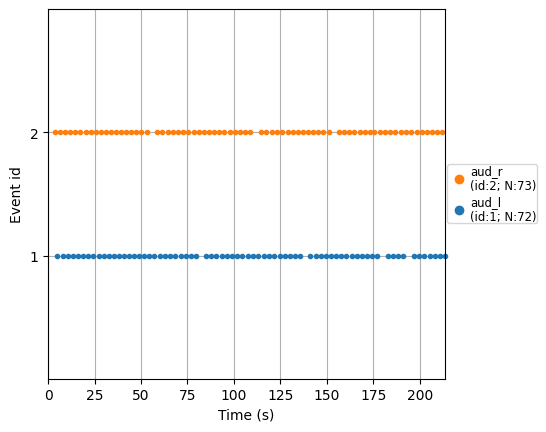

In [6]:
event_id = {'aud_l': 1, 'aud_r': 2}  # déclencheur d'événement et conditions
fig = mne.viz.plot_events(events, sfreq=raw.info['sfreq'],
                          first_samp=raw.first_samp, event_id=event_id)



Définir les paramètres des *epochs* :



In [7]:
tmin = -0.1  # début de chaque époque (en secondes)
tmax = 0.4   # fin de chaque époque
baseline = None  # pas de correction de ligne de base, les données ont été filtrées passe-haut

reject = dict(eeg=80e-6, eog=40e-6)
picks = mne.pick_types(raw.info, eeg=True, meg=True,
                       eog=True, stim=False, exclude='bads')

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline,
                    reject=reject, preload=True)  # avec preload

print(epochs.get_data(copy=True).shape)


(110, 365, 76)



## Décodage spatio-temporel

Voyons maintenant si nous pouvons distinguer les conditions expérimentales à partir d'essais individuels.  
Pour maintenir le niveau de chance à 50% de précision, nous équilibrons d'abord le nombre d'*epochs* dans chaque condition.



In [8]:
epochs.equalize_event_counts(event_id)
print(epochs)


<Epochs | 108 events (all good), -0.1 – 0.4 s (baseline off), ~26.1 MiB, data loaded,
 'aud_l': 54
 'aud_r': 54>



Un classifieur prend en entrée un `X` et renvoie `y` (0 ou 1). Ici, `X` sera les données à chaque point temporel sur tous les gradiomètres (d'où le terme multivarié). Nous voulons entraîner notre modèle à discriminer entre les essais `auditory left` et `auditory right`.

Nous cherchons à trouver un motif discriminant entre les deux conditions pour prédire la classe.

Pour la classification, nous utiliserons le package scikit-learn (http://scikit-learn.org/) et les fonctions MNE.

Créons d'abord le vecteur de réponse, `y`.



In [9]:
import numpy as np

y = np.empty(len(epochs.events), dtype=int)
idx_auditory_left = epochs.events[:, 2] == event_id['aud_l']
idx_auditory_right = epochs.events[:, 2] == event_id['aud_r']
y[idx_auditory_left] = 0
y[idx_auditory_right] = 1

y.size


108


Maintenant, la matrice d'entrée, `X`.



In [10]:
X = epochs.copy().pick_types(meg='grad').get_data()
X.shape  # n_epochs x n_chs x n_tp


(108, 203, 76)

In [11]:
XX = X.reshape(108, -1)
XX.shape


(108, 15428)


Ici, nous estimons la précision d'un classifieur [`Regression Logistique`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) en divisant les données, en ajustant un modèle et en calculant le score 5 fois consécutives (avec des divisions différentes à chaque fois) :



In [12]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

logreg = LogisticRegression(solver='liblinear')  # liblinear est l'algorithme utilisé pour ajuster le modèle
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = make_pipeline(StandardScaler(), logreg)

scores = cross_val_score(clf, XX, y, cv=cv, scoring='roc_auc')

roc_auc_mean = np.mean(scores)
roc_auc_std = np.std(scores)

print(f'Scores CV : {scores}')
print(f'ROC AUC moyenne = {roc_auc_mean:.3f} (écart-type : {roc_auc_std:.3f})')


Scores CV : [0.8677686  0.87603306 0.89256198 0.9        0.89090909]
ROC AUC moyenne = 0.885 (écart-type : 0.012)



Dans scikit-learn, [`Pipeline`](https://scikit-learn.org/stable/modules/compose.html#pipeline) peut être utilisé pour enchaîner plusieurs estimateurs en un seul.  
[`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold) est une variation de k-fold qui renvoie des *folds* (*folds*) stratifiés : chaque ensemble contient approximativement le même pourcentage d'échantillons de chaque classe cible que l'ensemble complet.  
[`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) renvoie le tableau des scores de l'estimateur pour chaque exécution de la validation croisée. Ici, nous utilisons l'aire sous la courbe (AUC) des courbes [`Receiver Operating Characteristic (ROC)`](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py).

### Utilisons le module `mne.decoding`



In [13]:
from sklearn.pipeline import make_pipeline
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore, LinearModel, get_coef



In [14]:
epochs_decoding = epochs.copy().pick_types(meg='grad')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = make_pipeline(Scaler(epochs_decoding.info),
                    Vectorizer(), 
                    logreg)

X = epochs_decoding.get_data()
y = epochs_decoding.events[:, 2]

scores = cross_val_multiscore(clf, X, y, cv=cv, scoring='roc_auc')

roc_auc_mean = np.mean(scores)
roc_auc_std = np.std(scores)

print(f'Scores CV : {scores}')
print(f'ROC AUC moyenne = {roc_auc_mean:.3f} (écart-type : {roc_auc_std:.3f})')


Scores CV : [0.90082645 0.90082645 0.95867769 0.93636364 0.91818182]
ROC AUC moyenne = 0.923 (écart-type : 0.022)



Le [`mne.decoding.Scaler`](https://mne.tools/stable/generated/mne.decoding.Scaler.html#mne.decoding.Scaler) met à l'échelle chaque canal en estimant μ et σ en utilisant les données de tous les points temporels et *epochs*. L'utilisation de cette classe est différente de l'application directe de [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) qui met à l'échelle chaque *folds* de classification, par exemple chaque point temporel pour chaque canal, avec la moyenne et l'écart-type calculés sur les *epochs*.  
Les transformateurs et estimateurs scikit-learn attendent généralement des données 2D (n_échantillons * n_*folds*s), alors que les transformateurs MNE produisent généralement des données avec une dimensionalité plus élevée (par exemple n_échantillons * n_canaux * n_temps). Un [`Vectorizer`](https://mne.tools/stable/generated/mne.decoding.Vectorizer.html#mne.decoding.Vectorizer) transforme un tableau n-dimensionnel en un tableau 2D de n_échantillons par n_*folds*s.

<div class="alert alert-success">
    <b>EXERCICES :</b>
     <ul>
      <li>Pourquoi obtenez-vous des résultats différents par rapport à ci-dessus ? </li>
      <li>Comment le choix de la validation croisée affecte-t-il les résultats ? Indice : Changez le random_state</li>
      <li>Essayez un objet de validation croisée différent comme scikit-learn KFold, StratifiedShuffleSplit</li>
      <li>Essayez un score différent dans la fonction cross_val_multiscore</li>
      <li>Quels types de capteurs donnent les meilleurs scores de classification ? EEG, gradiomètres MEG, magnétomètres MEG ?</li>
    </ul>
</div>

## Décodage au fil du temps

Dans les exemples précédents, nous avons entraîné un classifieur pour discriminer entre les conditions expérimentales en utilisant les patterns spatio-temporels d'**essais entiers**. Le classifieur a pu prédire quel motif d'activation appartenait à quelle condition.

Cependant, une question neuroscientifique intéressante est : **Exactement *quand* les signaux cérébraux pour deux conditions diffèrent-ils ?**

Nous pouvons essayer de répondre à cette question en entraînant un classifieur **à chaque point temporel individuel.** Si le classifieur peut discriminer avec succès entre les deux conditions, nous pouvons conclure que les patterns d'activation spatiale mesurés par les capteurs M/EEG différaient **à ce point temporel**.  
Cette stratégie consiste à ajuster un modèle prédictif multivarié à chaque instant temporel et à évaluer sa performance au même instant sur de nouvelles *epochs*.

Le [`mne.decoding.SlidingEstimator`](https://mne.tools/stable/generated/mne.decoding.SlidingEstimator.html#mne.decoding.SlidingEstimator) prendra en entrée une paire de *folds*s `X` et de cibles `y`, où `X` a plus de 2 dimensions.



Score CV moyen sur tous les points temporels : 0.590


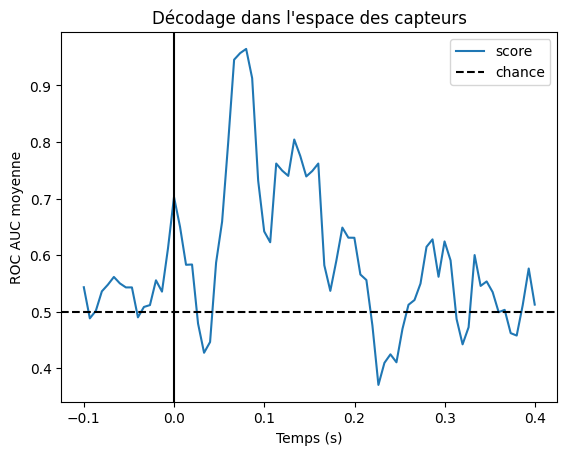

In [15]:
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator

X = epochs_decoding.get_data()
y = epochs_decoding.events[:, 2]


clf = make_pipeline(StandardScaler(),
                    logreg)

time_decod = SlidingEstimator(clf, scoring='roc_auc', n_jobs=1, verbose=True)
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Scores moyens à travers les divisions de validation croisée, pour chaque point temporel.
mean_scores = np.mean(scores, axis=0)

# Score moyen sur tous les points temporels.
mean_across_all_times = np.mean(scores)
print(f'Score CV moyen sur tous les points temporels : {mean_across_all_times:.3f}')

# Tracé
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(epochs.times, mean_scores, label='score')
ax.axhline(0.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Temps (s)')
ax.set_ylabel('ROC AUC moyenne')
ax.legend()
ax.axvline(0, color='k', linestyle='-')
ax.set_title('Décodage dans l\'espace des capteurs');



## Décodage des données dans l'espace des sources

Maintenant, nous voulons effectuer un décodage des données MEG dans l'espace des sources. Cela implique de résoudre le problème inverse (retrouver l'activité des sources à partir de celle des capteurs). Nous appliquons l'opérateur inverse pré-calculé aux essais individuels et utilisons dSPM comme méthode d'inversion.



In [16]:
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator

subjects_dir = data_path / "subjects"
fname_cov = data_path / "MEG/sample/sample_audvis-cov.fif"
fname_inv = data_path / "MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif"

epochs_meg = epochs.copy().pick_types(meg=True)

snr = 3.0

noise_cov = mne.read_cov(fname_cov)
inverse_operator = read_inverse_operator(fname_inv)

stcs = apply_inverse_epochs(
    epochs_meg,
    inverse_operator,
    lambda2=1.0 / snr**2,
    verbose=False,
    method="dSPM",
    pick_ori="normal",
)



`stcs` est une liste des séries temporelles reconstruites



In [17]:
stcs[0].rh_data.shape


(3766, 76)

In [18]:
# Récupérer les données de l'espace des sources dans un tableau
X = np.array([stc.data for stc in stcs])
y = epochs.events[:, 2]


print(X.shape, y.shape)
print(y)


(108, 7498, 76) (108,)
[1 2 1 2 1 2 1 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 1 2 1 2 2 1 2 1 2 1 2 1 2
 1 1 2 1 2 1 2 1 2 1 2 2 1 2 1 1 2 1 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 1]



Ici, la sélection de *folds*s univariée est employée pour des raisons de vitesse afin de limiter la classification à un petit nombre de *features* potentiellement pertinentes. Le classifieur est ensuite entraîné sur les *features* sélectionnées des *epochs* dans l'espace des sources.

Nous effectuons un décodage à chaque point temporel dans l'espace des sources en utilisant une régression logistique



In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# préparer une série de classifieurs appliqués à chaque échantillon temporel
clf = make_pipeline(
    StandardScaler(),  # normalisation z-score
    SelectKBest(f_classif, k=500),  # sélectionner des *folds*s pour la vitesse
    LinearModel(LogisticRegression(C=1, solver="liblinear")),
)
time_decod = SlidingEstimator(clf, scoring="roc_auc")

# Exécuter des analyses de décodage par validation croisée :
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)


  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/76 [00:00<?,       ?it/s]

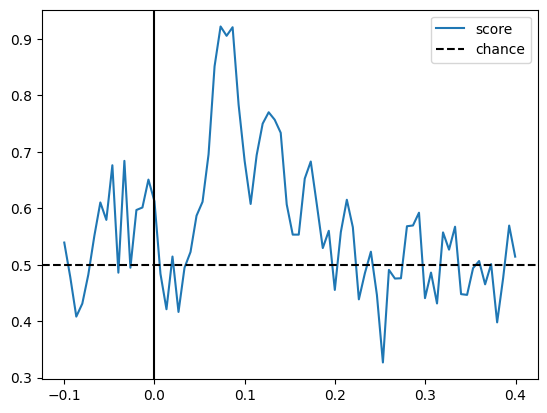

In [20]:
# Tracer les scores de décodage moyens de 5 divisions
fig, ax = plt.subplots(1)
ax.plot(epochs.times, scores.mean(0), label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.axvline(0, color="k")
plt.legend();


In [21]:
time_decod


<SlidingEstimator(base_estimator=Pipeline(steps=[('standardscaler', StandardScaler()), ('selectkbest', SelectKBest(k=500)), ('linearmodel', LinearModel(model=LogisticRegression(C=1, solver='liblinear')))]), scoring='roc_auc')>

In [ ]:
# L'ajustement n'a pas besoin d'être validé de manière croisée car les poids sont basés sur les ensembles d'entraînement
time_decod.fit(X, y)

# Récupérer les *patterns* après avoir inversé l'étape de normalisation z-score :
patterns = get_coef(time_decod, "patterns_", inverse_transform=True)   


In [ ]:
stc = stcs[0]  # pour plus de commodité, recherche des paramètres à partir du premier stc
vertices = [stc.lh_vertno, stc.rh_vertno]  # tableau vide pour l'hémisphère droit
stc_feat = mne.SourceEstimate(
    np.abs(patterns),
    vertices=vertices,
    tmin=stc.tmin,
    tstep=stc.tstep,
    subject="sample",
)


In [ ]:
patterns.shape


(7498, 76)


Pour visualiser les *patterns* dans l'espace des sources, vous devez installer les packages pyvistaqt et nibabel :  

`pip install pyvistaqt` et `pip install nibabel`.



In [25]:
brain = stc_feat.plot(
    hemi='both',
    views=["lat"],
    transparent=True,
    initial_time=0.1,
    time_unit="s",
    subjects_dir=subjects_dir,
)


False



<div class="alert alert-success">
    <b>EXERCICES :</b>
     <ul>
      <li>Tracez le score de décodage au fil du temps pour les différents types de canaux.</li>
         <li>Effectuez un décodage dans l'espace des sources</li>   
      <li>Effectuez un décodage au fil du temps sur le jeu de données SPM `face` pour voir si vous pouvez classifier `face` vs. `scrambled face`.</li>
         <li>Effectuez une analyse de généralisation au fil du temps.
</li>
    </ul>
</div>

Indices :

- Accédez au jeu de données `face` via :

    ```
    from mne.datasets import spm_face
    data_path = spm_face.data_path()

    raw_fname = os.path.join(data_path, 'MEG/spm/SPM_CTF_MEG_example_faces1_3D.ds')
    raw = mne.io.read_raw_ctf(raw_fname, preload=True)
    ```

- Les ID d'événements sont :

    ```
    event_ids = {"faces": 1, "scrambled": 2}
    ```

Voir cet exemple en ligne pour des indices supplémentaires : https://mne.tools/stable/auto_examples/datasets/spm_faces_dataset.html

<div class="alert alert-block alert-info">
<b>Note :</b> Pour plus de détails, consultez les tutoriels suivants : 
    <a href="https://mne.tools/stable/auto_tutorials/machine-learning/50_decoding.html" target="_blank">Décodage (MVPA)</a> et ce chapitre de livre :

Jean-Rémi King, Laura Gwilliams, Chris Holdgraf, Jona Sassenhagen, Alexandre Barachant, Denis Engemann, Eric Larson, Alexandre Gramfort. Encoding and Decoding Neuronal Dynamics: Methodological Framework to Uncover the Algorithms of Cognition. 2018. https://hal.archives-ouvertes.fr/hal-01848442/
</div># Statistiques multivariées (décodage / MVPA) sur M/EEG